#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [2]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
filename_suffix = 'csv'

In [3]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


In [4]:
print(df.columns.values)

['Lithology Code' 'Well Spacing' 'Net Pay Pay' 'Gross Pay' 'Porosity'
 'Swi' 'Oil FVFi' 'Temp' 'Permeability' 'API Gravity' 'Viscosity' 'OOIP'
 'Initial GOR' 'Pressure Initial' 'Fractured Faulted' 'Shale Breaks'
 'Major Gas Cap' 'Geologic Play' 'Deposition System'
 'Diagenetic Overprint' 'Structural Comp' 'Heterogeniety' 'Trap Type'
 'URF']


### Feature Selection

In [5]:
#Create a copy
df_train_test_set=df.copy()

Feature = df_train_test_set[[
    'Lithology Code', 
    'Well Spacing',
    'Net Pay Pay',
    'Gross Pay',
    'Porosity', 
    'Swi',
    'Oil FVFi',
    'Temp',
    'Permeability', 
    'API Gravity', 
    'Viscosity',
    'OOIP',
    'Initial GOR',
    'Pressure Initial',
    'Fractured Faulted',
    'Shale Breaks',
    'Major Gas Cap',
    'Geologic Play',
    'Deposition System',
    'Diagenetic Overprint',
    'Structural Comp',
    'Heterogeniety',
    'Trap Type'
]]
x=Feature

y = df_train_test_set['URF'].values

print(x.head())
print(y[0:5])
print(x.shape, y.shape)

   Lithology Code  Well Spacing  Net Pay Pay  Gross Pay  Porosity      Swi  \
0               1         120.0        320.0      600.0      14.0  40.0000   
1               1         160.0        100.0      160.0      18.1  35.0000   
2               1         160.0        100.0      300.0      15.7  51.6333   
3               1          80.0        350.0     1400.0      13.0  30.0000   
4               1         160.0        194.0      550.0      23.0  35.0000   

   Oil FVFi  Temp  Permeability  API Gravity  ...  Pressure Initial  \
0     1.586   153          10.0         41.0  ...            4251.0   
1     1.230   163          65.0         35.6  ...            4009.0   
2     1.190   185         102.0         32.9  ...            4457.0   
3     1.230   153           3.0         35.0  ...            3900.0   
4     1.380   200         450.0         27.0  ...            4300.0   

   Fractured Faulted  Shale Breaks  Major Gas Cap  Geologic Play  \
0                  0             0  

### Train-Test Split 70-30

In [6]:
from sklearn.model_selection import train_test_split

random_state = 42
test_size = 0.3

x_train, x_test, y_train, y_test  = train_test_split(
            x, y, test_size = test_size, random_state = random_state
)

print('Train Set: ', x_train.shape, y_train.shape)
print(x_train['Permeability'][0:5])
print('Test Set: ', x_test.shape, y_test.shape)
print(x_test['Permeability'][0:5])

Train Set:  (221, 23) (221,)
180      15.0
303      46.0
266       5.0
157       3.0
66     1000.0
Name: Permeability, dtype: float64
Test Set:  (96, 23) (96,)
73      50.0
280     38.0
25      70.0
255      5.0
9      400.0
Name: Permeability, dtype: float64


### Normalization as per Pycaret z-score

In [7]:
#https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

from sklearn.preprocessing import StandardScaler

X_train = preprocessing.StandardScaler().fit(x_train).transform(x_train)
X_test = preprocessing.StandardScaler().fit(x_test).transform(x_test)
print('Standardization X Training Set: ', X_train[0:5])
print('Standardization X Testing Set: ', X_test[0:5])

Standardization X Training Set:  [[-7.12836926e-01 -4.93495232e-01 -6.22497137e-01 -3.73078637e-01
  -1.02154633e+00  2.07406413e+00 -2.33349946e-01 -8.84660361e-01
  -2.31496028e-01  6.56055401e-01 -7.40229581e-02 -1.98355456e-01
  -3.32463525e-01 -7.61729773e-01 -7.38548946e-01 -1.27708746e+00
  -4.98585570e-01 -5.54445821e-01 -9.23021962e-01 -6.09101686e-01
   2.81501824e+00 -6.71477276e-01 -4.10992682e-01]
 [-7.12836926e-01  7.02447893e-01 -6.27744681e-01 -6.53129649e-01
  -5.12532727e-01 -2.63073147e-01 -1.10331477e+00 -1.67543575e-01
  -2.15112018e-01  4.98652572e-01 -7.41421078e-02 -1.81534412e-01
  -9.12356315e-01  1.81604030e-01 -7.38548946e-01 -1.27708746e+00
  -4.98585570e-01  3.32071741e-01 -1.45396380e+00 -6.09101686e-01
  -4.54851202e-01 -6.71477276e-01  1.12848838e+00]
 [ 2.86754854e+00 -3.56816018e-01  3.89529241e-01 -2.17494741e-01
  -7.84795819e-01 -1.58406378e+00  3.29568472e-01 -7.65140897e-01
  -2.36781193e-01  9.39024380e-02 -7.42329595e-02 -1.13603274e-01
   1.67

### Transformation as per Pycaret 'yeo johnson'

In [8]:
from sklearn.preprocessing import PowerTransformer

Xt_train = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train).transform(X_train)
Xt_test = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True).fit(X_test).transform(X_test)
print('Transformed X Training Set: ', Xt_train[0:5])
print('Transformed X Testing Set: ', Xt_test[0:5])

Transformed X Training Set:  [[-0.75076427 -0.87450604 -0.90962598 -0.1790188  -1.08045863  1.91349648
   0.00695917 -0.92921569 -0.77145029  0.61339858 -0.2915843  -0.76966279
  -0.12569466 -0.78815655 -0.73854895 -1.27708746 -0.49858557 -0.47876547
  -0.92368273 -0.76428771  2.00654947 -0.72737615 -0.4635568 ]
 [-0.75076427  1.39080303 -0.92754821 -0.91909413 -0.42776691 -0.20492642
  -1.57879401 -0.0073757  -0.5679578   0.42521714 -0.31468057 -0.51201143
  -1.19535806  0.4332552  -0.73854895 -1.27708746 -0.49858557  0.7986259
  -1.54132826 -0.76428771 -0.51930784 -0.72737615  1.16202125]
 [ 1.72745085 -0.34438564  1.0175186   0.14658789 -0.76753375 -1.70436326
   0.64281733 -0.76103323 -0.84020611 -0.02641739 -0.33236034  0.32513666
   0.50790625 -0.08148827 -0.73854895  0.78303173  2.00567377 -1.13360926
   1.15401759  1.06097169 -0.51930784  1.25716836  1.16202125]
 [ 1.27830771  1.39080303 -0.4601371   0.50796716 -0.19169844  0.00553924
   0.38895004  1.39878574 -0.85414434 -0.02

## Note that Ignore Low Variance and Remove Outliers is not implemented as it is assumed it will not make a significant difference to model

In [9]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

#### K-fold and grid search CV on 2 variables only

In [10]:
# Create a Random Forest Regressor
# win_rf=RandomForestRegressor(n_estimators=100, criterion="mse", max_depth=None, min_samples_split=2)
# win_rf.fit(Xt_train, y_train)
# yhat_rf = win_rf.predict(Xt_test)

def rfr_model(X, y, Xt):
# Perform Grid-Search
# bootstrap=True, ccp_alpha=0.0, criterion='mse',
# max_depth=None, max_features='auto', max_leaf_nodes=None,
# max_samples=None, min_impurity_decrease=0.0,
# min_impurity_split=None, min_samples_leaf=1,
# min_samples_split=2, min_weight_fraction_leaf=0.0,
# n_estimators=100, n_jobs=-1, oob_score=False,
# random_state=42, verbose=0, warm_start=False

    # Create Base Model
    rfr = RandomForestRegressor(
        bootstrap=True, ccp_alpha=0.0, criterion='mse',
        max_depth=None,
        max_features='auto', max_leaf_nodes=None,
        max_samples=None, min_impurity_decrease=0.0,
        min_impurity_split=None, min_samples_leaf=1,
        min_samples_split=2, min_weight_fraction_leaf=0.0,
        n_estimators=100, 
        n_jobs=-1, oob_score=False,
        random_state=42, verbose=0, warm_start=False
    )
    
    rfr.fit(X, y)
    predictions1 = rfr.predict(Xt)

    # Do Grid search
    gsc = GridSearchCV(
        estimator=rfr,
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    # Create K-fold Grid Model
    rfr2 = RandomForestRegressor(
        bootstrap=True, ccp_alpha=0.0, criterion='mse',
        max_depth=best_params["max_depth"],
        max_features='auto', max_leaf_nodes=None,
        max_samples=None, min_impurity_decrease=0.0,
        min_impurity_split=None, min_samples_leaf=1,
        min_samples_split=2, min_weight_fraction_leaf=0.0,
        n_estimators=best_params["n_estimators"], 
        n_jobs=-1, oob_score=False,
        random_state=42, verbose=0, warm_start=False
    )    
  
    rfr2.fit(X, y)
    # Perform K-Fold CV
    scores = cross_val_score(rfr2, X, y, cv=10, scoring='neg_mean_absolute_error')
        
    # Predict
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    predictions2 = rfr2.predict(Xt)
    
    return scores, predictions1, predictions2, rfr, rfr2

In [11]:
win_rf_grid, yhat_rf, yhat_rf_grid, rfr, rfr_grid = rfr_model(Xt_train, y_train, Xt_test)
print("MAE Score", win_rf_grid)

errors1 = abs(yhat_rf - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors1), 2), 'V/V')
mape1 = np.mean(100 * (errors1 / y_test))
accuracy1 = 100 - mape1
print('Accuracy:', round(accuracy1, 2), '%.')

errors2 = abs(yhat_rf_grid - y_test)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'V/V')
mape2 = np.mean(100 * (errors2 / y_test))
accuracy2 = 100 - mape2
print('Accuracy:', round(accuracy2, 2), '%.')

MAE Score [-0.08956269 -0.07468653 -0.06417149 -0.09426012 -0.08360356 -0.07919998
 -0.08870773 -0.07566295 -0.05763505 -0.06716025]
Mean Absolute Error: 0.09 V/V
Accuracy: 52.16 %.
Mean Absolute Error: 0.09 V/V
Accuracy: 52.73 %.


Text(0, 0.5, 'Evaluated Recovery Factor (%)')

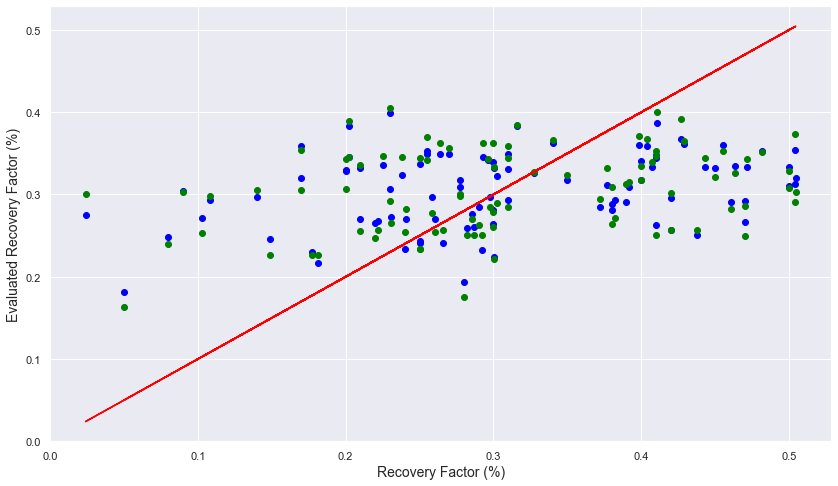

In [12]:
a = y_test
b = yhat_rf_grid
c = yhat_rf

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

In [13]:
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,95.05,28.7,98.4,17.55,42.85,1.19,139,100.0,39.65,...,1,1,0,39,132,1,30,2,2,0.310
1,1,160.54,286.0,323.0,23.00,28.00,1.40,201,76.0,33.00,...,1,1,0,427,181,1,30,3,3,0.280
2,1,20.00,8.6,12.0,30.00,32.00,1.10,118,1200.0,17.00,...,1,0,0,2407,151,1,10,1,2,0.274
3,1,10.00,10.0,60.0,25.00,40.00,1.10,110,1500.0,34.00,...,0,1,0,2407,151,1,10,1,1,0.360
4,1,20.00,20.0,140.0,25.00,25.00,1.06,120,1000.0,20.00,...,0,1,1,2407,151,1,10,1,2,0.330


### Blind Data Set

In [14]:
blind_df = dfblind.copy()
blind_df.drop(['URF'], axis=1, inplace=True)

In [15]:
blind_df_norm = preprocessing.StandardScaler().fit(blind_df).transform(blind_df)
blind_df_norm_tran = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True).fit(blind_df_norm).transform(blind_df_norm)

In [16]:
print(dfblind['URF'])

0     0.310000
1     0.280000
2     0.274000
3     0.360000
4     0.330000
        ...   
69    0.390000
70    0.470000
71    0.371956
72    0.140187
73    0.450000
Name: URF, Length: 74, dtype: float64


In [17]:
predictions = rfr.predict(blind_df_norm_tran)
print(predictions)

predictions_grid = rfr_grid.predict(blind_df_norm_tran)
print(predictions_grid)

[0.3586235  0.30253351 0.28457128 0.30692295 0.33407642 0.32680612
 0.37246381 0.29870194 0.31496887 0.31161277 0.21101661 0.32297482
 0.31608158 0.31026385 0.21632567 0.26745987 0.34156718 0.3155352
 0.33239774 0.33267872 0.32003044 0.32388164 0.25773799 0.34641367
 0.34126688 0.29311555 0.32737188 0.37246267 0.34721115 0.3833807
 0.23980989 0.34614758 0.35570804 0.3654107  0.36524758 0.34321535
 0.24976337 0.23896707 0.23787132 0.25758186 0.33487718 0.28070565
 0.26243749 0.31381425 0.23200226 0.29631453 0.33354742 0.303994
 0.18866927 0.3171851  0.33183882 0.33757526 0.29144603 0.2599076
 0.31850172 0.29750951 0.28784368 0.27367631 0.31739229 0.31072795
 0.29510438 0.29668385 0.27807478 0.340517   0.35009726 0.34614594
 0.36765794 0.36508522 0.28896862 0.33303036 0.34185725 0.36699318
 0.3557882  0.39058228]
[0.36269696 0.31283244 0.29130317 0.31255913 0.31873377 0.31794787
 0.35301323 0.3108126  0.32423637 0.31811103 0.2215271  0.33055678
 0.32527543 0.31346336 0.22644119 0.2532039

Text(0, 0.5, 'Evaluated Recovery Factor (%)')

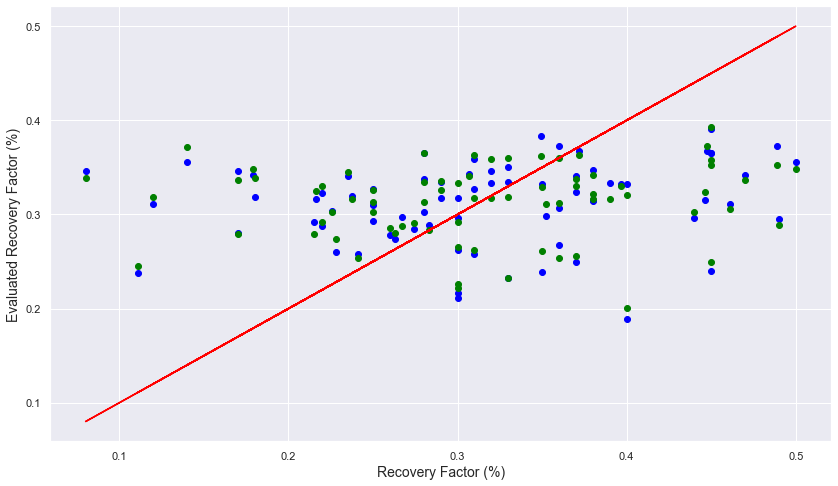

In [18]:
a = dfblind['URF']
b = predictions
c = predictions_grid

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)